In [7]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
pip install imbalanced-learn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
pip install category_encoders


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 3.2 MB/s eta 0:00:00


In [2]:
pip install boruta


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.3 MB/s eta 0:00:00


# 1.0 Data Description

## 1.1 Loading Dataset

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from scipy import stats
from boruta import BorutaPy

from category_encoders import OneHotEncoder

# Assume `X` is your input data as a Pandas 
import imblearn
from imblearn.under_sampling import NearMiss

In [9]:
df=pd.read_csv("/content/Fraud (1).csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


## 1.2 Column Descriptions

#### step:
maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation)

#### type: 
CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

#### amount: 
amount of the transaction in local currency.

#### nameOrig:
customer who started the transaction

#### oldbalanceOrg: 
initial balance before the transaction

#### newbalanceOrig: 
new balance after the transaction

#### nameDest:
customer who is the recipient of the transaction

#### oldbalanceDest: 
initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

#### newbalanceDest: 
new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

#### isFraud: 
This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

#### isFlaggedFraud: 
The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

## 1.3 Data Types and Structure

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110813 entries, 0 to 110812
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            110813 non-null  int64  
 1   type            110813 non-null  object 
 2   amount          110813 non-null  float64
 3   nameOrig        110813 non-null  object 
 4   oldbalanceOrg   110813 non-null  float64
 5   newbalanceOrig  110813 non-null  float64
 6   nameDest        110813 non-null  object 
 7   oldbalanceDest  110813 non-null  float64
 8   newbalanceDest  110812 non-null  float64
 9   isFraud         110812 non-null  float64
 10  isFlaggedFraud  110812 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 9.3+ MB


## 1.4 Data Dimension 

In [ ]:
 df.shape

(42271, 11)

## 1.5 Checking for null values

In [11]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64

### There are no Null values to fill.

### Checking for Corelation

In [12]:
df.corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.073929,-0.000696,-0.000864,0.010927,0.010933,-0.050454,NaN
amount,0.073929,1.000000,-0.012842,-0.018990,0.241862,0.370074,0.037206,NaN
oldbalanceOrg,-0.000696,-0.012842,1.000000,0.998911,0.100822,0.070228,-0.003736,NaN
newbalanceOrig,-0.000864,-0.018990,0.998911,1.000000,0.102394,0.069191,-0.010312,NaN
oldbalanceDest,0.010927,0.241862,0.100822,0.102394,1.000000,0.940235,-0.009178,NaN
newbalanceDest,0.010933,0.370074,0.070228,0.069191,0.940235,1.000000,-0.006218,NaN
isFraud,-0.050454,0.037206,-0.003736,-0.010312,-0.009178,-0.006218,1.000000,NaN
isFlaggedFraud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,110813.000000,1.108130e+05,1.108130e+05,1.108130e+05,1.108130e+05,1.108120e+05,110812.000000,110812.0
mean,8.664958,1.759051e+05,8.941414e+05,9.101840e+05,8.871676e+05,1.186291e+06,0.001083,0.0
std,1.809812,3.470360e+05,2.779029e+06,2.816472e+06,2.393870e+06,2.778425e+06,0.032890,0.0
min,1.000000,3.200000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,8.000000,1.023470e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,9.000000,5.524493e+04,2.021200e+04,0.000000e+00,2.290103e+04,6.055630e+04,0.000000,0.0
75%,10.000000,2.145087e+05,1.985740e+05,2.239154e+05,6.103005e+05,1.083858e+06,0.000000,0.0
max,11.000000,1.000000e+07,3.893942e+07,3.894623e+07,3.400874e+07,3.894623e+07,1.000000,0.0


## Description Statistics

In [14]:
num_attributes = df.select_dtypes(exclude='object')
cat_attributes = df.select_dtypes(include='object')

## To check on various statistical charachteristics of numerical features

In [15]:
num_attributes.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,110813.000000,1.108130e+05,1.108130e+05,1.108130e+05,1.108130e+05,1.108120e+05,110812.000000,110812.0
mean,8.664958,1.759051e+05,8.941414e+05,9.101840e+05,8.871676e+05,1.186291e+06,0.001083,0.0
std,1.809812,3.470360e+05,2.779029e+06,2.816472e+06,2.393870e+06,2.778425e+06,0.032890,0.0
min,1.000000,3.200000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,8.000000,1.023470e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,9.000000,5.524493e+04,2.021200e+04,0.000000e+00,2.290103e+04,6.055630e+04,0.000000,0.0
75%,10.000000,2.145087e+05,1.985740e+05,2.239154e+05,6.103005e+05,1.083858e+06,0.000000,0.0
max,11.000000,1.000000e+07,3.893942e+07,3.894623e+07,3.400874e+07,3.894623e+07,1.000000,0.0


1) All the data has a coeficient of variation greater than 25%, therefore they aren't homogeneous.

2) The step variable starts from 1 hour to 742 hour (30 days).

3) Some variables are higher shap and right skewed.

4) 50% of the newbalance_orig is 0. Maybe there are some transfers that don't go to the destination.


## Distribution of categorical features

In [16]:
cat_attributes.describe()

,type,nameOrig,nameDest
count,110813,110813,110813
unique,5,110813,56413
top,PAYMENT,C1231006815,C985934102
freq,43315,1,78


1) The majority type is cash_out with 2237500.

2) There's a lot of variability in name_orig, so it could be hard to use one hot encoding.

3) There's less name_orig than name_dest. There's more users sending than receiving, however use one hot encoding will not help.

4) There's more fraud than the flagged fraud, it shows that the current method can't recognize fraud efficiently.

## Feature Engineering

In [17]:
f_e=df.copy()
#creating new features for days and weeks
f_e['step_days'] = f_e['step'].apply(lambda i: i/24)
f_e['step_weeks'] = f_e['step'].apply(lambda i: i/(24*7))

# difference between initial balance before the transaction and new balance after the transaction
f_e['diff_new_old_balance'] = f_e['newbalanceOrig'] - f_e['oldbalanceOrg']

# difference between initial balance recipient before the transaction and new balance recipient after the transaction.
f_e['diff_new_old_destiny'] = f_e['newbalanceDest'] - f_e['oldbalanceDest']

# name orig and name dest
f_e['nameOrig'] = f_e['nameOrig'].astype(str)
f_e['nameOrig'] = f_e['nameOrig'].apply(lambda i: i[0])


In [18]:
d_fe=f_e.copy()

### Outlier Detection

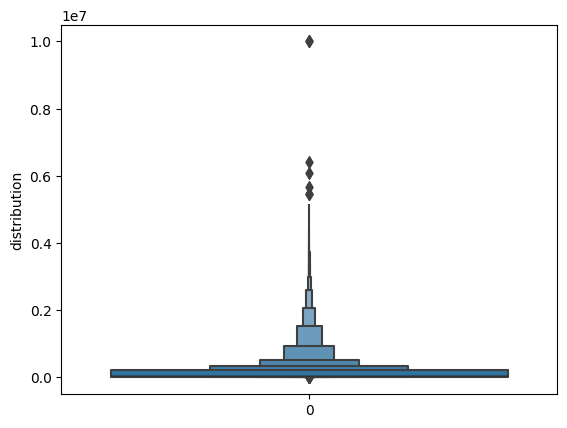

In [19]:
sns.boxenplot(df['amount'])
plt.ylabel('distribution')
plt.show()

Text(0, 0.5, 'distribution')

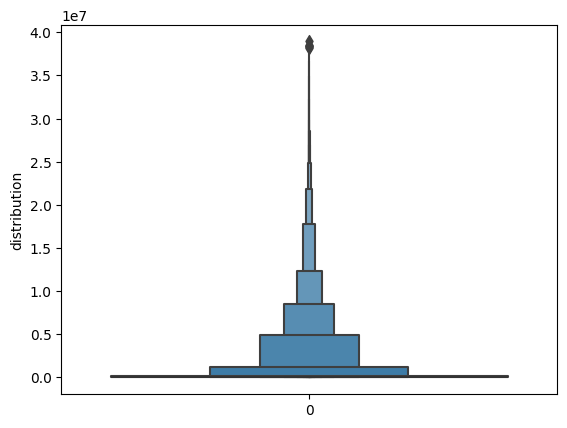

In [ ]:
sns.boxenplot(df['oldbalanceOrg'])
plt.ylabel('distribution')

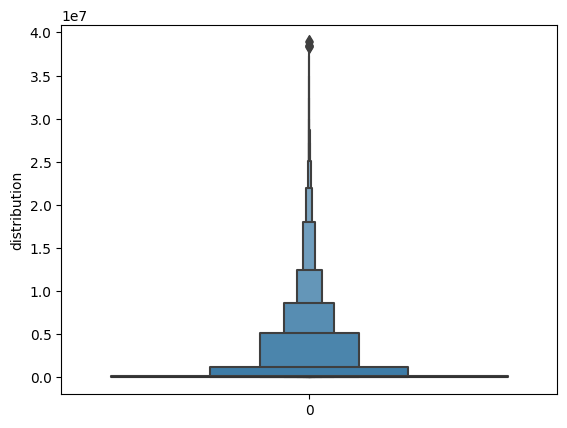

In [ ]:
sns.boxenplot(df['newbalanceOrig'])
plt.ylabel('distribution')
plt.show()

Text(0, 0.5, 'distribution')

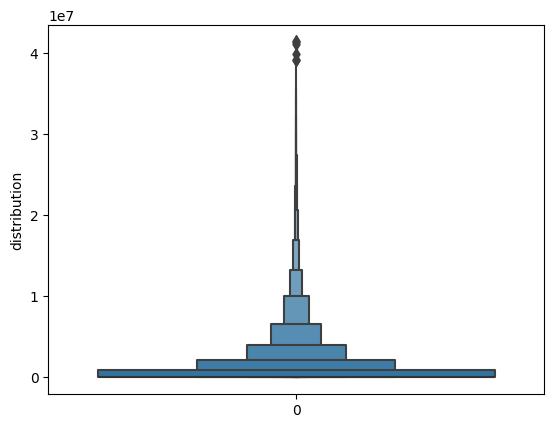

In [ ]:
sns.boxenplot(df['oldbalanceDest'])
plt.ylabel('distribution')

Text(0, 0.5, 'distribution')

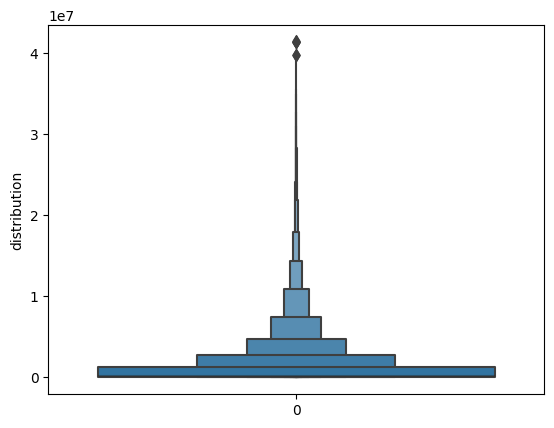

In [ ]:
sns.boxenplot(df['newbalanceDest'])
plt.ylabel('distribution')

In [ ]:
def remove_outliers(d_fe,col):
    lower_quantile = d_fe[col].quantile(0.25)
    upper_quantile = d_fe[col].quantile(0.75)
    IQR = upper_quantile - lower_quantile
    lower_whisker = lower_quantile - 1.5 * IQR
    upper_whisker = upper_quantile + 1.5 * IQR
    temp = d_fe.loc[(df[col]>lower_whisker)&(df[col]<upper_whisker)]
    return temp[col]

In [ ]:
d_fe['amount'] = remove_outliers(df,'amount')
d_fe['oldbalanceOrg'] = remove_outliers(d_fe,'oldbalanceOrg')
d_fe['newbalanceOrig'] = remove_outliers(d_fe,'newbalanceOrig')
d_fe['oldbalanceDest'] = remove_outliers(d_fe,'oldbalanceDest')
d_fe['newbalanceDest'] = remove_outliers(d_fe,'newbalanceDest')

<Axes: >

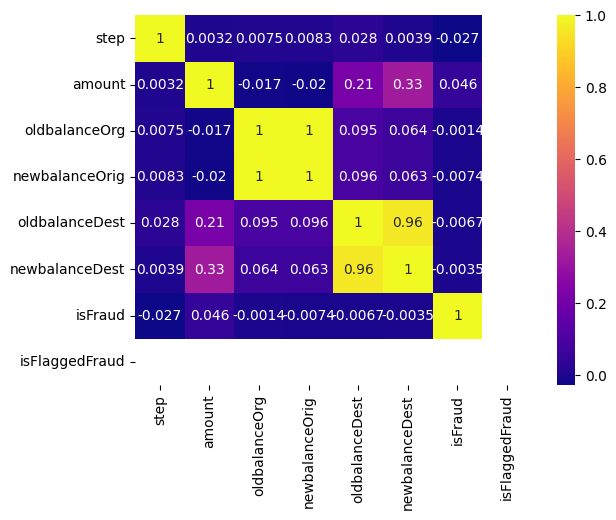

In [ ]:
sns.heatmap(num_attributes.corr(),annot=True,cmap='plasma')

# Things we can conclude from this heatmap:
### 1)OldbalanceOrg and NewbalanceOrg are highly correlated.
### 2)OldbalanceDest and NewbalanceDest are highly correlated.
### 3)Amount is correlated with isFraud(Target Variable).
### 4)There is not much relation between the features, so we need to understand where the relationship between them depends on the type of transaction and amount. To do so, we need to see the heat map of fraud and nonfraud transactions differently.¶

## Response Variable

In [ ]:
df['isFraud'] = df['isFraud'].map({1: 'yes', 0: 'no'})
df['isFlaggedFraud'] = df['isFlaggedFraud'].map({1: 'yes', 0: 'no'})

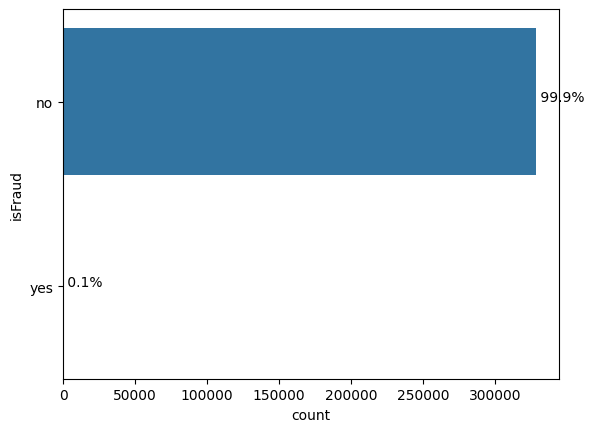

In [ ]:
ax=sns.countplot(y="isFraud",data=df)
total = df['isFraud'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

Text(0, 0.5, 'Target Variable')

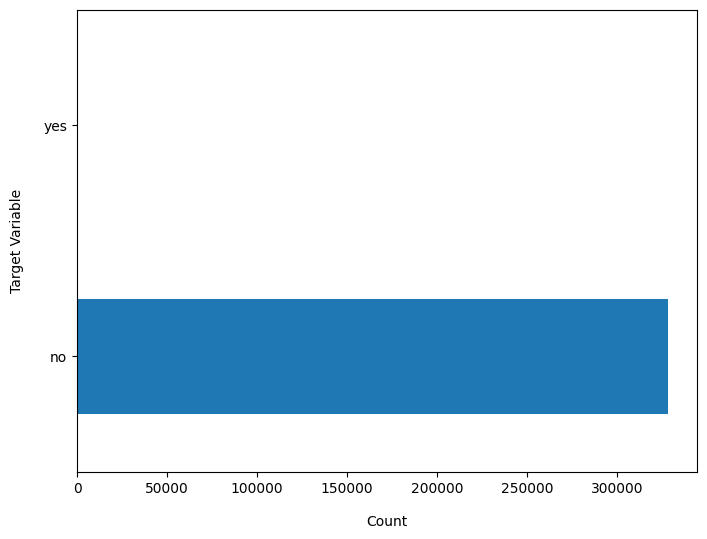

In [ ]:
df['isFraud'].value_counts().plot(kind='barh', figsize=(8, 6))
plt.xlabel("Count", labelpad=14)
plt.ylabel("Target Variable", labelpad=14)

In [ ]:
100*df['isFraud'].value_counts()/len(df['isFraud'])

no     99.941500
yes     0.058195
Name: isFraud, dtype: float64

#### Numerical Variables

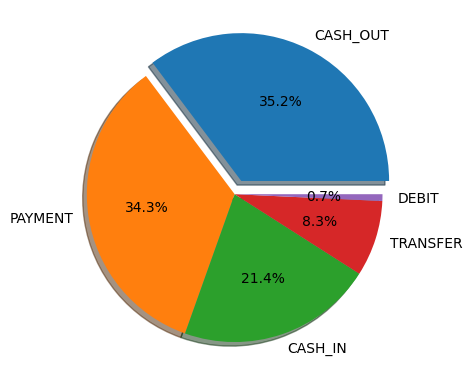

In [ ]:
values = df['type'].value_counts().values
labels = df['type'].value_counts().keys()
explode = (0.1,0,0,0,0)

plt.pie(values,labels=labels,explode=explode,shadow=True,autopct='%1.1f%%')
plt.show()

A vast majority of the transactions are of the type CASH_OUT having an overall proportion of a little more than one-third, closely followed by Payment mode having a share of nearly 34%. The proportion of CASH_IN transaction stood at just over one-fifth, even though, the percentage of debit and normal transfer transactions had a minimal share of less than one-tenth.

Just a tiny fraction of the total transactions in the given dataset are fraud which indicates that this is a highly imbalanced dataset.
### Let's find out the maximum transferred amount by type.

In [ ]:
max_amount_type = df.groupby('type')['amount'].max().sort_values(ascending=False).reset_index()[:10]
max_amount_type

,type,amount
0,CASH_OUT,10000000.00
1,TRANSFER,10000000.00
2,CASH_IN,1289407.91
3,DEBIT,150053.28
4,PAYMENT,92057.11


<Axes: xlabel='type', ylabel='amount'>

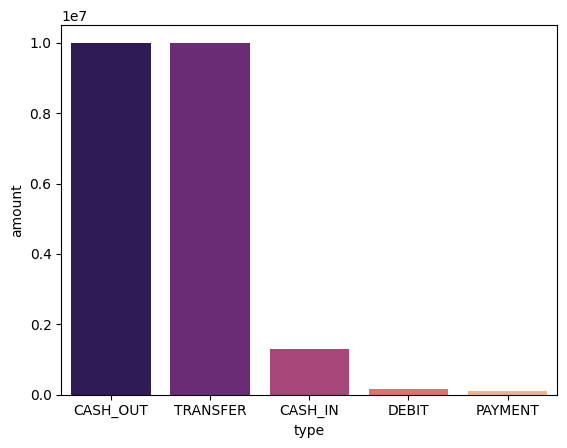

In [ ]:
sns.barplot(x='type',y='amount',data=max_amount_type,palette='magma')

### The highest amount was transferred through normal transfer mode while the least money was transferred by payment

<Axes: ylabel='count'>

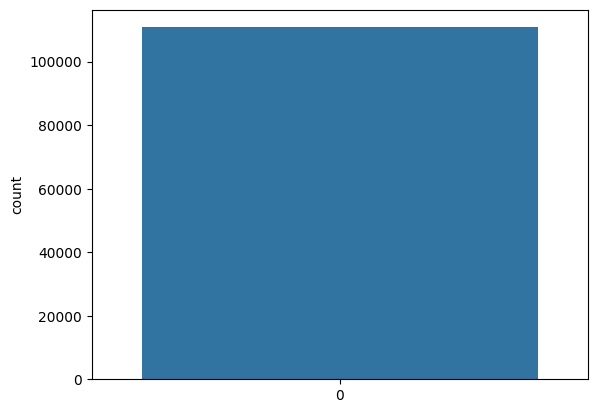

In [20]:
sns.countplot(df['isFraud'])

### This is an imbalanced dataset as almost all the samples provided in the dataset belong to the majority class label 'Not Fraud'.

<Axes: xlabel='amount', ylabel='Density'>

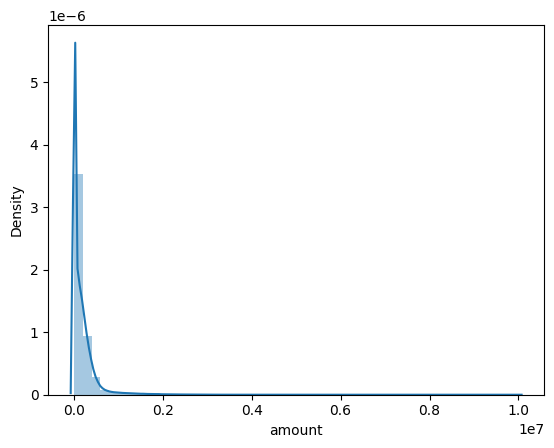

In [ ]:
sns.distplot(df['amount'],bins=50)

### All the balances, either old or new, of both the sender as well as the receiver have a positively right skewed distribution so let's perform normalization of each of these variables.

<Axes: xlabel='oldbalanceDest', ylabel='newbalanceDest'>

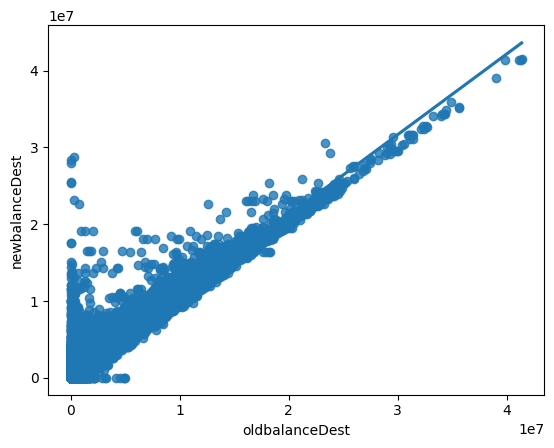

In [ ]:
sns.regplot(x='oldbalanceDest',y='newbalanceDest',data=df.sample(100000))

## Data Preparation

In [ ]:
d_fe['amount'].fillna(d_fe['amount'].mean(),inplace=True)
d_fe['oldbalanceOrg'].fillna(d_fe['oldbalanceOrg'].mean(),inplace=True)
d_fe['newbalanceOrig'].fillna(d_fe['newbalanceOrig'].mean(),inplace=True)
d_fe['oldbalanceDest'].fillna(d_fe['oldbalanceDest'].mean(),inplace=True)
d_fe['newbalanceDest'].fillna(d_fe['newbalanceDest'].mean(),inplace=True)
# difference between initial balance before the transaction and new balance after the transaction
d_fe['diff_new_old_balance'] = d_fe['newbalanceOrig'] - d_fe['oldbalanceOrg']

# difference between initial balance recipient before the transaction and new balance recipient after the transaction.
d_fe['diff_new_old_destiny'] = d_fe['newbalanceDest'] - d_fe['oldbalanceDest']

In [ ]:
d_fe

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,step_days,step_weeks,diff_new_old_balance,diff_new_old_destiny
0,1,PAYMENT,9839.64,C,170136.000000,160296.360000,M1979787155,0.000000,0.000000,0.0,0.0,0.041667,0.005952,-9839.640000,0.000000
1,1,PAYMENT,1864.28,C,21249.000000,19384.720000,M2044282225,0.000000,0.000000,0.0,0.0,0.041667,0.005952,-1864.280000,0.000000
2,1,TRANSFER,181.00,C,181.000000,0.000000,C553264065,0.000000,0.000000,1.0,0.0,0.041667,0.005952,-181.000000,0.000000
3,1,CASH_OUT,181.00,C,181.000000,0.000000,C38997010,21182.000000,0.000000,1.0,0.0,0.041667,0.005952,-181.000000,-21182.000000
4,1,PAYMENT,11668.14,C,41554.000000,29885.860000,M1230701703,0.000000,0.000000,0.0,0.0,0.041667,0.005952,-11668.140000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14242,8,PAYMENT,20924.47,C,18265.000000,0.000000,M1309313968,0.000000,0.000000,0.0,0.0,0.333333,0.047619,-18265.000000,0.000000
14243,8,CASH_OUT,75244.54,C,38369.000000,0.000000,C1292445663,167.000000,0.000000,0.0,0.0,0.333333,0.047619,-38369.000000,-167.000000
14244,8,PAYMENT,3074.36,C,10242.000000,7167.640000,M2001030591,0.000000,0.000000,0.0,0.0,0.333333,0.047619,-3074.360000,0.000000
14245,8,PAYMENT,11465.21,C,38.000000,0.000000,M1222093409,0.000000,0.000000,0.0,0.0,0.333333,0.047619,-38.000000,0.000000


In [ ]:
# Convert Dtypes :
d_fe[d_fe.select_dtypes(['int64','int16','float32','float64','int8']).columns] = d_fe[d_fe.select_dtypes(['int64','int16','float32','float64','int8']).columns].apply(pd.to_numeric)
d_fe[d_fe.select_dtypes(['object','category']).columns] = d_fe.select_dtypes(['object','category']).apply(lambda x: x.astype('category'))

In [ ]:
d_fe

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,step_days,step_weeks,diff_new_old_balance,diff_new_old_destiny
0,1,PAYMENT,9839.64,C,170136.000000,160296.360000,M1979787155,0.000000,0.000000,0.0,0.0,0.041667,0.005952,-9839.640000,0.000000
1,1,PAYMENT,1864.28,C,21249.000000,19384.720000,M2044282225,0.000000,0.000000,0.0,0.0,0.041667,0.005952,-1864.280000,0.000000
2,1,TRANSFER,181.00,C,181.000000,0.000000,C553264065,0.000000,0.000000,1.0,0.0,0.041667,0.005952,-181.000000,0.000000
3,1,CASH_OUT,181.00,C,181.000000,0.000000,C38997010,21182.000000,0.000000,1.0,0.0,0.041667,0.005952,-181.000000,-21182.000000
4,1,PAYMENT,11668.14,C,41554.000000,29885.860000,M1230701703,0.000000,0.000000,0.0,0.0,0.041667,0.005952,-11668.140000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14242,8,PAYMENT,20924.47,C,18265.000000,0.000000,M1309313968,0.000000,0.000000,0.0,0.0,0.333333,0.047619,-18265.000000,0.000000
14243,8,CASH_OUT,75244.54,C,38369.000000,0.000000,C1292445663,167.000000,0.000000,0.0,0.0,0.333333,0.047619,-38369.000000,-167.000000
14244,8,PAYMENT,3074.36,C,10242.000000,7167.640000,M2001030591,0.000000,0.000000,0.0,0.0,0.333333,0.047619,-3074.360000,0.000000
14245,8,PAYMENT,11465.21,C,38.000000,0.000000,M1222093409,0.000000,0.000000,0.0,0.0,0.333333,0.047619,-38.000000,0.000000


## Splitting Data into train and test

In [ ]:
X = d_fe.drop(columns=['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest', 
                      'step_weeks', 'step_days'], axis=1)
     
y = df['isFraud'].map({'yes': 1, 'no': 0})

In [ ]:
X

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,diff_new_old_balance,diff_new_old_destiny
0,1,PAYMENT,9839.64,170136.000000,160296.360000,0.000000,0.000000,-9839.640000,0.000000
1,1,PAYMENT,1864.28,21249.000000,19384.720000,0.000000,0.000000,-1864.280000,0.000000
2,1,TRANSFER,181.00,181.000000,0.000000,0.000000,0.000000,-181.000000,0.000000
3,1,CASH_OUT,181.00,181.000000,0.000000,21182.000000,0.000000,-181.000000,-21182.000000
4,1,PAYMENT,11668.14,41554.000000,29885.860000,0.000000,0.000000,-11668.140000,0.000000
...,...,...,...,...,...,...,...,...,...
328202,16,CASH_OUT,342652.71,13821.000000,0.000000,428435.760000,961299.920000,-13821.000000,532864.160000
328203,16,CASH_IN,423512.90,113430.000000,536942.900000,5202.000000,244574.950000,423512.900000,239372.950000
328204,16,PAYMENT,15217.04,46794.159229,521725.860000,0.000000,0.000000,474931.700771,0.000000
328205,16,CASH_OUT,501066.44,17517.000000,0.000000,0.000000,189892.090000,-17517.000000,189892.090000


In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [ ]:
num_attributes=X.select_dtypes(exclude="object").columns
cat_attributes=X.select_dtypes(include="object").columns

In [ ]:
num_transformer=StandardScaler()
cat_transformer=OneHotEncoder()

In [ ]:
preprocessor=ColumnTransformer(
   [
       ("OneHotEncoder",cat_transformer,cat_attributes),
       ("StandardScaler",num_transformer,num_attributes)
       
   ]
)
X=preprocessor.fit_transform(X)

In [ ]:
X

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.16296883e-01, -7.63719839e-02,  1.63171393e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.16296883e-01,  1.64294961e-01,  1.63171393e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.16296883e-01,  2.15090142e-01,  1.63171393e-01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.16296883e-01,  1.27779210e-01,  1.63171393e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.16296883e-01,  2.19405354e-01,  1.63171393e-01],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         7.06836826e-17,  0.00000000e+00,  5.97592319e-17]])

In [ ]:
y.fillna(y.mode()[0], inplace=True)
y

0        0.0
1        0.0
2        1.0
3        1.0
4        0.0
        ... 
14242    0.0
14243    0.0
14244    0.0
14245    0.0
14246    0.0
Name: isFraud, Length: 14247, dtype: float64

In [ ]:
# spliting into temp and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=.2, stratify=y)
# spliting into train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=.2, stratify=y_temp)

In [ ]:
X_params=X_temp.copy()

## Feature Selection

## Machine Learning Modeling

In [ ]:
def ml_scores(model_name, y_true, y_pred):
    
    accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    
    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 3), 
                         'Precision': np.round(precision, 3), 
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3),
                         'Kappa': np.round(kappa, 3)}, 
                        index=[model_name])

In [ ]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, balanced_accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def ml_cv_results(model_name, model, x, y, verbose=1):
    
    '''initial'''
    scoring = {'accuracy': make_scorer(balanced_accuracy_score),
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1': make_scorer(f1_score),
               'kappa': make_scorer(cohen_kappa_score)}
    
    '''cross-validation'''
    cv_results = cross_validate(model, x, y, cv=5, scoring=scoring)
    
    '''results'''    
    accuracy_mean, accuracy_std = np.round(np.mean(cv_results['test_accuracy']), 3), np.round(np.std(cv_results['test_accuracy']), 3)
    precision_mean, precision_std = np.round(np.mean(cv_results['test_precision']), 3), np.round(np.std(cv_results['test_precision']), 3)
    recall_mean, recall_std = np.round(np.mean(cv_results['test_recall']), 3), np.round(np.std(cv_results['test_recall']), 3)
    f1_mean, f1_std = np.round(np.mean(cv_results['test_f1']), 3), np.round(np.std(cv_results['test_f1']), 3)
    kappa_mean, kappa_std = np.round(np.mean(cv_results['test_kappa']), 3), np.round(np.std(cv_results['test_kappa']), 3)
    
    ## saving the results in a dataframe
    return pd.DataFrame({"Balanced Accuracy": "{} +/- {}".format(accuracy_mean, accuracy_std),
                        "Precision": "{} +/- {}".format(precision_mean, precision_std),
                        "Recall": "{} +/- {}".format(recall_mean, recall_std),
                        "F1": "{} +/- {}".format(f1_mean, f1_std),
                        "Kappa": "{} +/- {}".format(kappa_mean, kappa_std)},
                       index=[model_name])


In [ ]:
from sklearn.dummy        import DummyClassifier
dummy = DummyClassifier()
dummy.fit(X_train, y_train)

y_pred = dummy.predict(X_valid)

In [ ]:
dummy_results = ml_scores('dummy', y_valid, y_pred)
dummy_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.5,0.0,0.0,0.0,0.0


## Classification Report

In [ ]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2268
         1.0       0.00      0.00      0.00        12

    accuracy                           0.99      2280
   macro avg       0.50      0.50      0.50      2280
weighted avg       0.99      0.99      0.99      2280



## Cross Validation

In [ ]:
dummy_cv = ml_cv_results('Dummy', DummyClassifier(), X_temp, y_temp)
dummy_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
Dummy,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0


## Logistic Regression

In [ ]:
lg = LogisticRegression()
lg.fit(X_train, y_train)
y_pred = lg.predict(X_valid)


In [ ]:
lg_results = ml_scores('Logistic Regression', y_valid, y_pred)
lg_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.5,0.0,0.0,0.0,0.0


## Classification Report

In [ ]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2268
         1.0       0.00      0.00      0.00        12

    accuracy                           0.99      2280
   macro avg       0.50      0.50      0.50      2280
weighted avg       0.99      0.99      0.99      2280



In [ ]:
#Cross Validation
lg_cv = ml_cv_results('Logistic Regression',
                      LogisticRegression(), 
                      X_temp, y_temp)
lg_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,-0.0 +/- 0.0


In [ ]:
knn_results = ml_scores('K Nearest Neighbors', y_valid, y_pred)
knn_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.5,0.0,0.0,0.0,0.0


## Classification Report


In [ ]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2268
         1.0       0.00      0.00      0.00        12

    accuracy                           0.99      2280
   macro avg       0.50      0.50      0.50      2280
weighted avg       0.99      0.99      0.99      2280



## Cross Validation

In [ ]:
knn_cv = ml_cv_results('K Nearest Neighbors', KNeighborsClassifier(), 
                       X_temp, y_temp)
knn_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.611 +/- 0.066,0.6 +/- 0.343,0.222 +/- 0.132,0.315 +/- 0.178,0.313 +/- 0.178


## Support Vector Machine


In [ ]:
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_valid)


In [ ]:
svm_results = ml_scores('SVM', y_valid, y_pred)
svm_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.5,0.0,0.0,0.0,0.0


## Classification Report


In [ ]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2268
         1.0       0.00      0.00      0.00        12

    accuracy                           0.99      2280
   macro avg       0.50      0.50      0.50      2280
weighted avg       0.99      0.99      0.99      2280



In [ ]:
#Cross Validation
svm_cv = ml_cv_results('SVM', SVC(), X_temp, y_temp)
svm_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0


## Random Forest


In [ ]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_valid)


In [ ]:
rf_results = ml_scores('Random Forest', y_valid, y_pred)
rf_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.792,1.0,0.583,0.737,0.736


## Classification Report


In [ ]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2268
         1.0       1.00      0.58      0.74        12

    accuracy                           1.00      2280
   macro avg       1.00      0.79      0.87      2280
weighted avg       1.00      1.00      1.00      2280



## Cross Validation


In [ ]:
rf_cv = ml_cv_results('Random Forest', 
                      RandomForestClassifier(), 
                      X_temp, y_temp)
rf_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.758 +/- 0.085,0.964 +/- 0.073,0.515 +/- 0.171,0.648 +/- 0.149,0.647 +/- 0.149


## XGBoost


In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_valid)

In [ ]:
xgb_results = ml_scores('XGBoost', y_valid, y_pred)
xgb_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.792,1.0,0.583,0.737,0.736


In [ ]:
#Classification Report
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2268
         1.0       1.00      0.58      0.74        12

    accuracy                           1.00      2280
   macro avg       1.00      0.79      0.87      2280
weighted avg       1.00      1.00      1.00      2280



In [ ]:
#Cross Validation
xgb_cv = ml_cv_results('XGBoost', XGBClassifier(),
                       X_temp, y_temp)
xgb_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.861 +/- 0.064,0.93 +/- 0.058,0.722 +/- 0.128,0.81 +/- 0.1,0.809 +/- 0.101


In [ ]:
## 7.7 LightGBM


In [ ]:
lightgbm = LGBMClassifier()
lightgbm.fit(X_train, y_train)



LGBMClassifier()

In [ ]:
y_pred = lightgbm.predict(X_valid)
lightgbm_results = ml_scores('LightGBM', y_valid, y_pred)
lightgbm_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
LightGBM,0.791,0.875,0.583,0.7,0.699


In [ ]:
## 7.7.1 Classification Report
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2268
         1.0       0.88      0.58      0.70        12

    accuracy                           1.00      2280
   macro avg       0.94      0.79      0.85      2280
weighted avg       1.00      1.00      1.00      2280



In [ ]:
## 7.7.2 Cross Validation
lightgbm_cv = ml_cv_results('LightGDM', LGBMClassifier(), 
                            X_temp, y_temp)
lightgbm_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
LightGDM,0.805 +/- 0.081,0.85 +/- 0.136,0.612 +/- 0.161,0.701 +/- 0.135,0.699 +/- 0.136


In [ ]:
modeling_performance = pd.concat([dummy_results, lg_results, knn_results, 
                                  rf_results, xgb_results, 
                                 svm_results,lightgbm_results])
modeling_performance.sort_values(by="F1", ascending=True)

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.500,0.000,0.000,0.000,0.000
Logistic Regression,0.500,0.000,0.000,0.000,0.000
K Nearest Neighbors,0.500,0.000,0.000,0.000,0.000
SVM,0.500,0.000,0.000,0.000,0.000
LightGBM,0.791,0.875,0.583,0.700,0.699
Random Forest,0.792,1.000,0.583,0.737,0.736
XGBoost,0.792,1.000,0.583,0.737,0.736


## Cross Validation Performance


In [ ]:
modeling_performance_cv = pd.concat([dummy_cv, lg_cv, knn_cv, rf_cv, 
                                     xgb_cv, lightgbm_cv, svm_cv])

modeling_performance_cv.sort_values(by="F1", ascending=True)

,Balanced Accuracy,Precision,Recall,F1,Kappa
Dummy,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0
Logistic Regression,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,-0.0 +/- 0.0
SVM,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0
K Nearest Neighbors,0.611 +/- 0.066,0.6 +/- 0.343,0.222 +/- 0.132,0.315 +/- 0.178,0.313 +/- 0.178
Random Forest,0.758 +/- 0.085,0.964 +/- 0.073,0.515 +/- 0.171,0.648 +/- 0.149,0.647 +/- 0.149
LightGDM,0.805 +/- 0.081,0.85 +/- 0.136,0.612 +/- 0.161,0.701 +/- 0.135,0.699 +/- 0.136
XGBoost,0.861 +/- 0.064,0.93 +/- 0.058,0.722 +/- 0.128,0.81 +/- 0.1,0.809 +/- 0.101


In [ ]:
## 8.0 Hyperparameter Fine Tuning
f1 = make_scorer(f1_score)


In [ ]:
params = {
    'booster': ['gbtree', 'gblinear', 'dart'],
    'eta': [0.3, 0.1, 0.01],
    'scale_pos_weight': [1, 774, 508, 99]
}


In [ ]:
gs = GridSearchCV(XGBClassifier(), 
                  param_grid=params, 
                  scoring=f1, 
                  cv=StratifiedKFold(n_splits=5))

gs.fit(X_params, y_temp)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'booster': ['gbtree', 'gblinear', 'dart'],
                         'eta': [0.3, 0.1, 0.01],
                         'scale_pos_weight': [1, 774, 508, 99]},
             scoring=make_scorer(f1_score))

In [ ]:
best_params = gs.best_params_
best_params


{'booster': 'gbtree', 'eta': 0.3, 'scale_pos_weight': 99}

In [ ]:

best_params = {'booster': 'gbtree', 'eta': 0.3, 'scale_pos_weight': 1}


In [ ]:
gs.best_score_

0.8327494982667396

In [ ]:
## Results

In [ ]:
xgb_gs = XGBClassifier(
    booster=best_params['booster'],
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)


In [ ]:
xgb_gs.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
y_pred = xgb_gs.predict(X_valid)


In [ ]:
## 8.1.2 Single Results
xgb_gs_results = ml_scores('XGBoost GS', y_valid, y_pred)
xgb_gs_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost GS,0.792,1.0,0.583,0.737,0.736


In [ ]:
## 8.1.3 Cross Validation
xgb_gs_cv = ml_cv_results('XGBoost GS', xgb_gs, X_temp, y_temp)
xgb_gs_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost GS,0.861 +/- 0.064,0.93 +/- 0.058,0.722 +/- 0.128,0.81 +/- 0.1,0.809 +/- 0.101


In [ ]:
## Final Model
final_model = XGBClassifier(
    booster=best_params['booster'],
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)



In [ ]:
final_model.fit(X_params, y_temp)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
y_pred = final_model.predict(X_test)
unseen_scores = ml_scores('unseen', y_test, y_pred)
unseen_scores

,Balanced Accuracy,Precision,Recall,F1,Kappa
unseen,0.875,0.857,0.75,0.8,0.799


## What are the key factors that predict fraudulent customer?
High transaction amounts: Large amounts of money being transferred or withdrawn from an account may indicate fraudulent activity.

Unusual transaction patterns: Sudden changes in transaction patterns, such as a customer who has only made small purchases suddenly making large ones, may indicate fraudulent activity.

Geographical anomalies: Transactions made from different locations within a short period may indicate fraudulent activity.

Customer history: Past fraudulent activity may indicate a likelihood of future fraudulent activity.

Suspicious account activity: Accounts that are opened with false identification, or accounts that have multiple users who all access the account from different locations, may indicate fraudulent activity.

## Do these factors make sense? If yes, How? If not, How not?
Yes, these factors make sense and are commonly used in fraud detection. High transaction amounts can be an indicator of fraudulent activity as fraudsters often try to withdraw or transfer large sums of money. Unusual transaction patterns such as sudden changes in purchase amounts can also be an indicator of fraudulent activity. Geographical anomalies can also be a sign of fraud, as transactions from different locations within a short period of time can be suspicious. Looking at customer history is also a common factor in fraud detection, as past fraudulent activity can indicate a likelihood of future fraudulent activity. Finally, monitoring suspicious account activity, such as accounts opened with false identification or accounts accessed from multiple locations, can also be an indicator of fraudulent activity.

## What kind of prevention should be adopted while company update its infrastructure?
It's important to implement various preventive measures to prevent fraudulent transactions. Some of the prevention methods that can be adopted are:
Regularly monitoring transactions: A company can monitor transactions regularly and identify any suspicious or unusual transaction patterns.

Implementing security protocols: Companies should have security protocols in place that require strong passwords, two-factor authentication, and encryption of sensitive data.

Updating software and systems: Regular updates to software and systems can help to prevent security breaches, such as malware or viruses, that can lead to fraudulent activity.

Conducting regular risk assessments: Regular risk assessments can help to identify potential vulnerabilities in the company's infrastructure and address them before fraudulent activity occurs.

Educating employees and customers: Employees and customers should be educated about the risks of fraud and how to identify and report suspicious activity.

Conducting background checks: Conducting background checks on employees who have access to sensitive information and financial transactions can help prevent internal fraud.

## Assuming these actions have been implemented, how would you determine if they workTo determine if the implemented actions are effective in preventing fraudulent transactions, you can track and analyze the following metrics:

Reduction in fraud incidents: If the implemented measures are effective, there should be a noticeable reduction in the number of fraudulent transactions over time.

Reduction in financial losses: If the implemented measures are effective, there should be a decrease in financial losses due to fraudulent transactions.

Increase in customer trust: If the implemented measures are effective, customers should have a higher level of trust in the company's ability to prevent fraudulent transactions.

Compliance with regulations: If the implemented measures are effective, the company should be in compliance with relevant regulations related to fraud prevention